# STORMS PREDICTION MODEL

The following data analysis have the goal on creating a model which is able to predict the number of tropical storms and hurricanes by season in the Atlantic Ocean (The Atlantic Hurricane seasons runs from June 1st to November 30th every year). 



### 1. Load python packages

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.backend_bases import MouseButton
from matplotlib import dates as mdates

In [4]:
import missingno as msno
from pandas.api.types import CategoricalDtype
from thefuzz import fuzz
from thefuzz import process
from datetime import datetime

pd.options.display.float_format = "{:,.2f}".format

In [5]:

import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose


In [6]:
storms_uniq = pd.read_csv('../data/storms_uniq.csv', index_col='date')

In [7]:
storms_uniq.head(5)

,year,month,day,hour,lat,long,status,category,wind,pressure,tropicalstorm_force_diameter,hurricane_force_diameter
date,,,,,,,,,,,,
1975-06-28,1975,6,28,18,34.00,-77.00,tropical depression,0.00,30,1006,125.47,4.56
1975-07-26,1975,7,26,0,31.00,-75.00,tropical depression,0.00,30,1005,125.47,4.56
1975-09-01,1975,9,1,0,25.10,-98.30,tropical depression,0.00,30,1000,125.47,4.56
1975-09-24,1975,9,24,0,35.50,-84.30,tropical depression,0.00,30,999,125.47,4.56
1975-09-25,1975,9,25,0,23.80,-57.20,tropical depression,0.00,30,1005,125.47,4.56


In [8]:
# Time series:  
# Line charts
# Moving average
# Rolling mean

In [9]:
storms_uniq.index = pd.to_datetime(storms_uniq.index)

In [10]:
storms_uniq.status.value_counts()

status
tropical depression    248
tropical storm         213
hurricane              173
Name: count, dtype: int64

In [11]:
storms_uniq.sort_index(inplace=True)

In [12]:
storms_uniq = storms_uniq.loc[storms_uniq.index > '2016-01-01',:]

In [13]:
categorical_features = ['status']
storms_uniq = pd.get_dummies(storms_uniq, columns = categorical_features,dtype=float)
print('The data have ', storms_uniq.shape[0], ' rows and ', storms_uniq.shape[1], ' columns\n')
print('column names: \n')
print('\n'.join(list(storms_uniq.columns)))



The data have  260  rows and  14  columns

column names: 

year
month
day
hour
lat
long
category
wind
pressure
tropicalstorm_force_diameter
hurricane_force_diameter
status_hurricane
status_tropical depression
status_tropical storm


In [14]:
storms_uniq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260 entries, 2016-01-14 to 2021-11-06
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          260 non-null    int64  
 1   month                         260 non-null    int64  
 2   day                           260 non-null    int64  
 3   hour                          260 non-null    int64  
 4   lat                           260 non-null    float64
 5   long                          260 non-null    float64
 6   category                      260 non-null    float64
 7   wind                          260 non-null    int64  
 8   pressure                      260 non-null    int64  
 9   tropicalstorm_force_diameter  260 non-null    float64
 10  hurricane_force_diameter      260 non-null    float64
 11  status_hurricane              260 non-null    float64
 12  status_tropical depression    260 non-null   

In [15]:
storms_uniq['status_hurricane_cumm'] = storms_uniq['status_hurricane'].cumsum()
storms_uniq['status_tropical depression_cumm'] = storms_uniq['status_tropical depression'].cumsum()
storms_uniq['status_tropical storm_cumm'] = storms_uniq['status_tropical storm'].cumsum()

In [16]:
storms_uniq.sort_index(inplace=True)

In [17]:
storms_uniq['status_tropical storm_cumm'].tail(5)

date
2021-09-24   110.00
2021-09-26   110.00
2021-10-01   111.00
2021-10-04   111.00
2021-11-06   112.00
Name: status_tropical storm_cumm, dtype: float64

In [18]:
class_counts = storms_uniq[['status_hurricane','status_tropical depression','status_tropical storm']].value_counts().reset_index()
class_counts

,status_hurricane,status_tropical depression,status_tropical storm,count
0,0.00,0.00,1.00,112
1,0.00,1.00,0.00,96
2,1.00,0.00,0.00,52


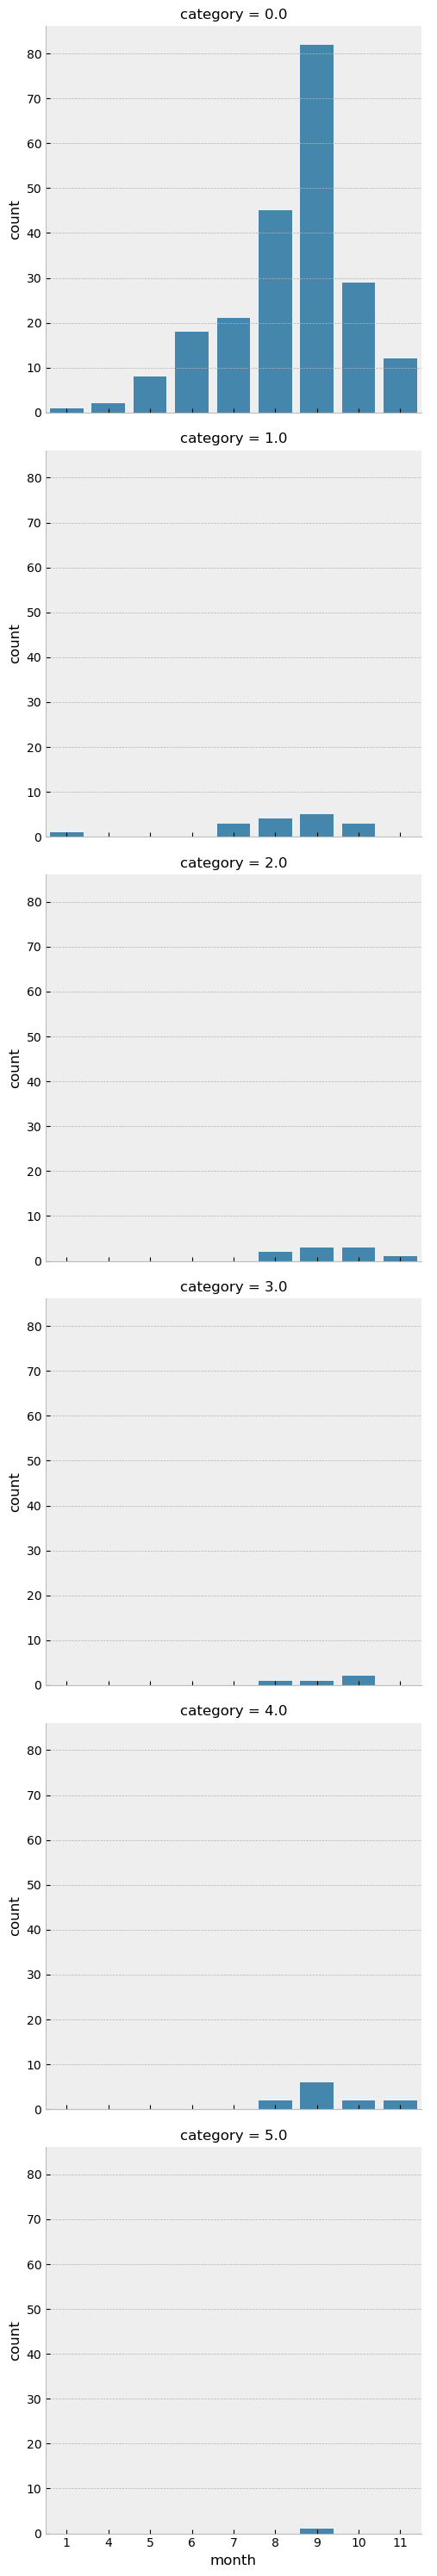

In [19]:
plt.style.use('bmh')

ax = sns.catplot(x='month',
            data=storms_uniq,
            row='category',
            kind='count')   
    

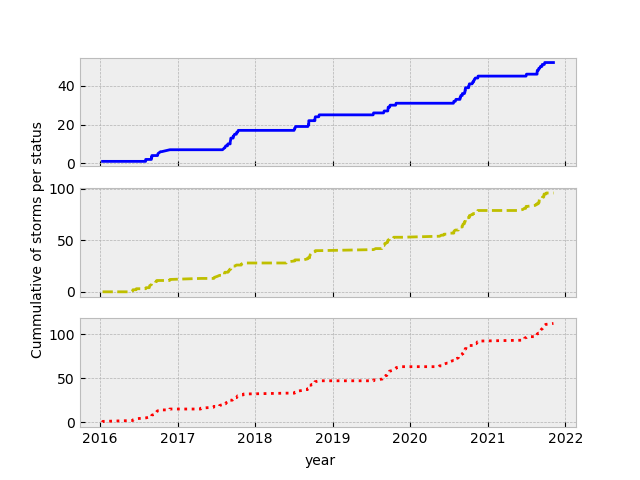

In [94]:
fig, ax = plt.subplots(3, 1, sharex=True)


ax[0].plot(storms_uniq.index, storms_uniq['status_hurricane_cumm'], color = 'b')
ax[1].plot(storms_uniq.index, storms_uniq['status_tropical depression_cumm'], color = 'y', linestyle = '--')
ax[2].plot(storms_uniq.index, storms_uniq['status_tropical storm_cumm'], color = 'r', linestyle = ':')

fig.text(0.5, 0.04, 'year', ha='center', va='center')
fig.text(0.06, 0.5, 'Cummulative of storms per status', ha='center', va='center', rotation='vertical')

plt.show()

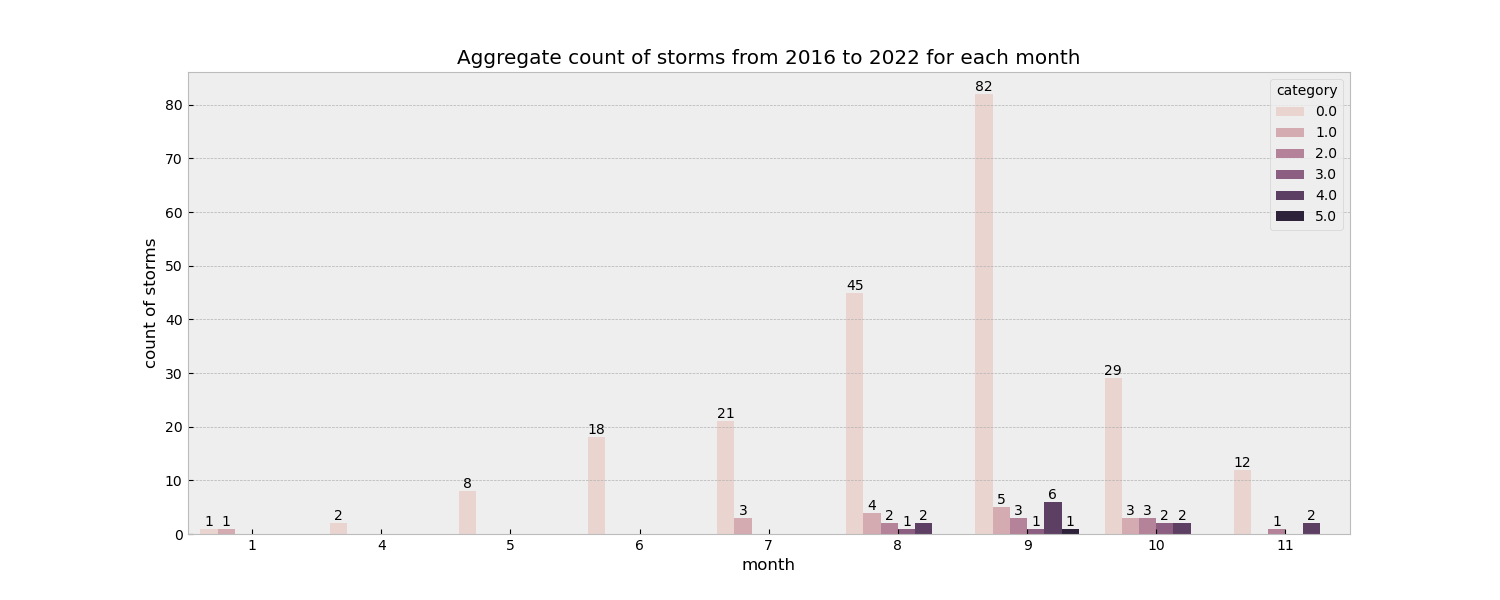

In [63]:
## Figure showing the aggregate counts of storms per month from 2016 to 2022.

fig, ax_m = plt.subplots(figsize=(15,6))

ax_m = sns.countplot(data=storms_uniq, x = storms_uniq.index.month, hue='category')

for container in ax_m.containers:
    ax_m.bar_label(container)

ax_m.set_xlabel('month')
ax_m.set_ylabel('count of storms')
ax_m.set_title('Aggregate count of storms from 2016 to 2022 for each month')

plt.show()

In [43]:
def plot_timeseries(axes, x, y, color, xlabel, ylabel,label=None):
    axes.plot(x,y,color=color,label=label)
#    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel, color=color)
    axes.tick_params('y',colors=color)
    # Minor ticks every month.
    fmt_month = mdates.MonthLocator()
    # Minor ticks every year.
    fmt_year = mdates.YearLocator()

    ax.xaxis.set_minor_locator(fmt_month)
    # '%b' to get the names of the month
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(fmt_year)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    # fontsize for month labels
    ax.tick_params(labelsize=8, which='both')
    # create a second x-axis beneath the first x-axis to show the year in YYYY format
    sec_xaxis = ax.secondary_xaxis(-0.1)
    sec_xaxis.xaxis.set_major_locator(fmt_year)
    sec_xaxis.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Hide the second x-axis spines and ticks
    sec_xaxis.spines['bottom'].set_visible(False)
    sec_xaxis.tick_params(length=0, labelsize=10)


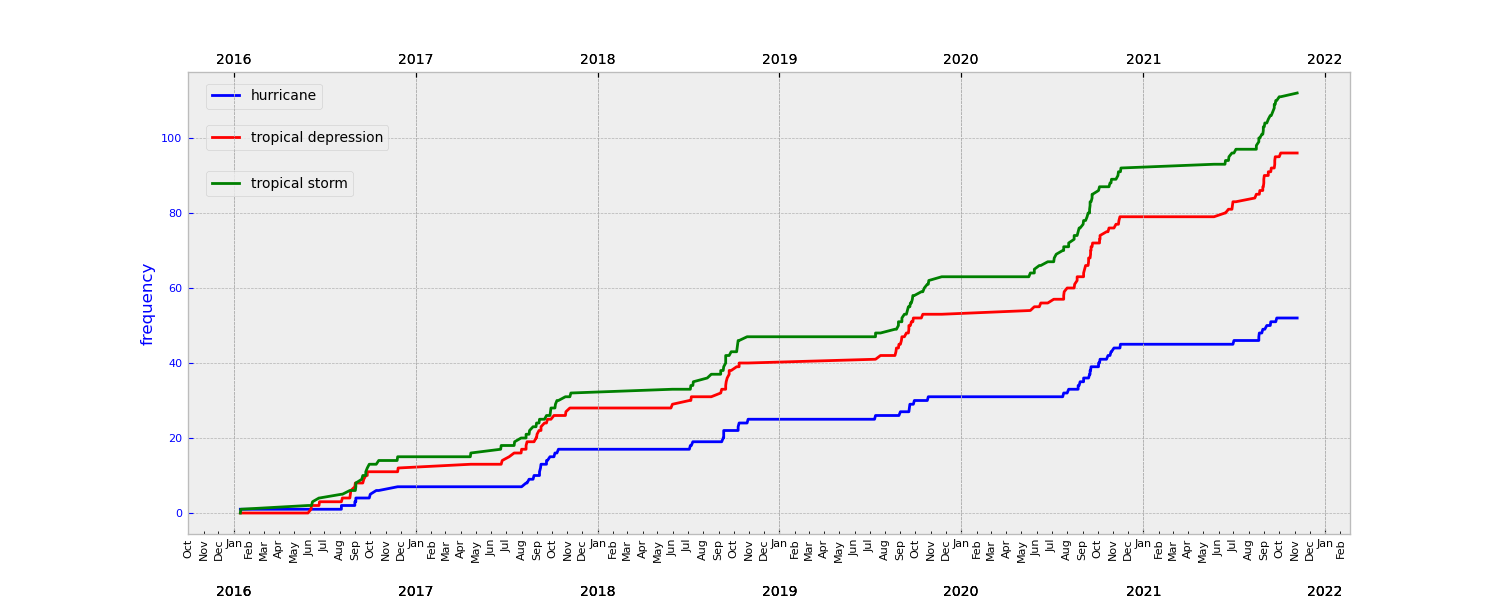

In [81]:
%matplotlib widget
#%matplotlib notebook

fig, ax = plt.subplots(figsize=(15,6))

plot_timeseries(ax, storms_uniq.index, storms_uniq['status_hurricane_cumm'],'blue','Time','frequency',label='hurricane')

ax2 = ax.twiny()

plot_timeseries(ax2, storms_uniq.index, storms_uniq['status_tropical depression_cumm'],'red','Time','frequency',label='tropical depression')

ax3 = ax.twiny()

plot_timeseries(ax3, storms_uniq.index, storms_uniq['status_tropical storm_cumm'],'green','Time','Tropical depression & storm timeline',label='tropical storm')

ax.legend(loc='upper left', bbox_to_anchor=(0.01, 0.99))
ax2.legend(loc='upper left', bbox_to_anchor=(0.01, 0.90))
ax3.legend(loc='upper left', bbox_to_anchor=(0.01, 0.80))



def on_move(event):
    # get the x and y pixel coords
    x, y = event.x, event.y
    if event.inaxes:
        ax = event.inaxes  # the axes instance
        print('data coords %f %f' % (event.xdata, event.ydata))
    if event.inaxes:
        print(f'data coords {event.xdata} {event.ydata},',
              f'pixel coords {event.x} {event.y}')


def on_click(event):
    if event.button is MouseButton.LEFT:
        print('disconnecting callback')
        plt.disconnect(binding_id)

cid = fig.canvas.mpl_connect('button_press_event', on_move)

binding_id = plt.connect('motion_notify_event', on_move)
plt.connect('button_press_event', on_click)

plt.setp(ax.xaxis.get_minorticklabels(),rotation=90)

plt.ion()

plt.show()


In [162]:
storms_ts = storms_uniq.loc[storms_uniq.index.year == 2021,['status_hurricane_cumm','status_tropical depression_cumm','status_tropical storm_cumm']]

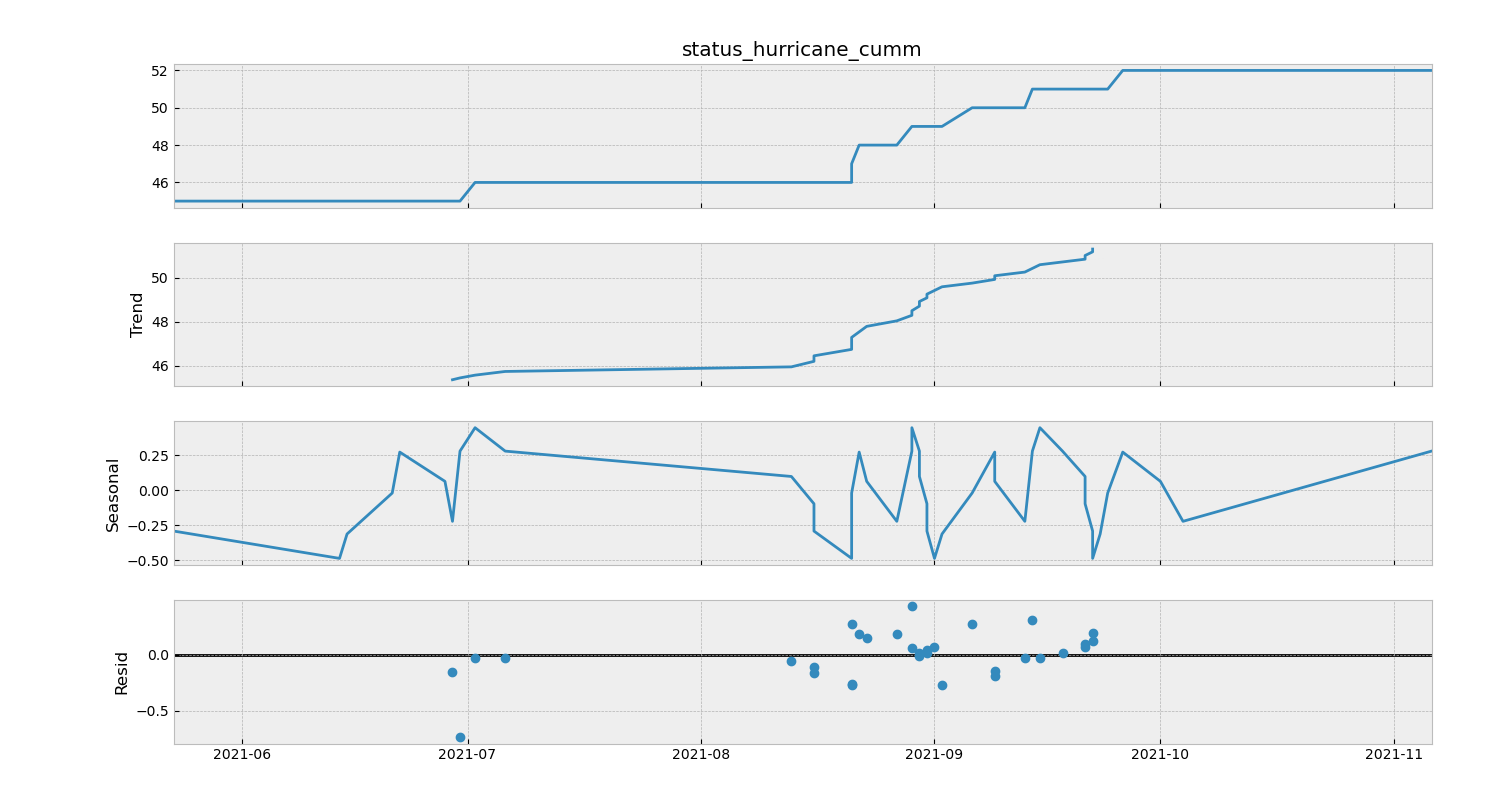

In [164]:
decomposition = seasonal_decompose(storms_ts['status_hurricane_cumm'], period=12)  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

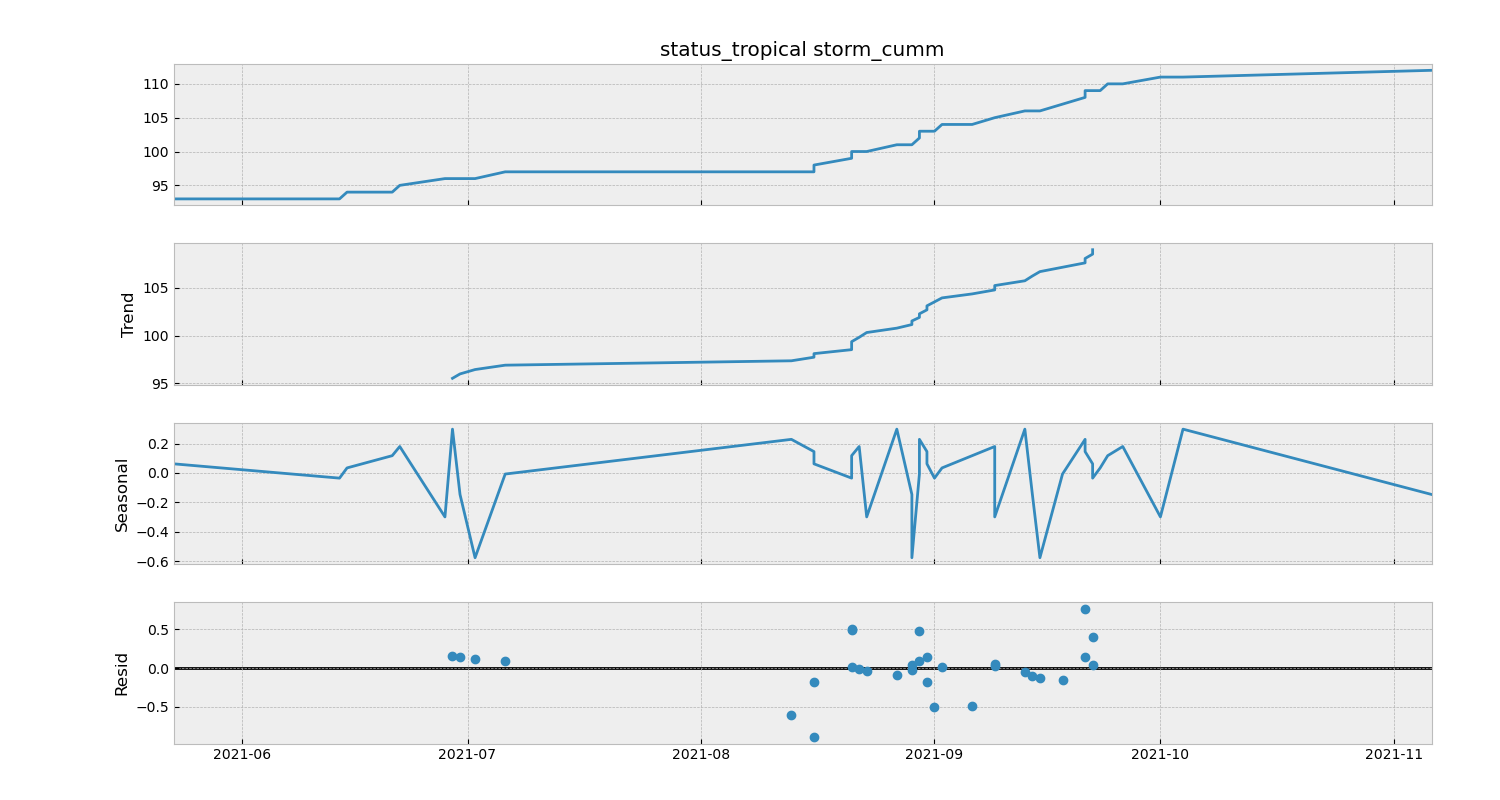

In [166]:
decomposition = seasonal_decompose(storms_ts['status_tropical storm_cumm'], period=12)    
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

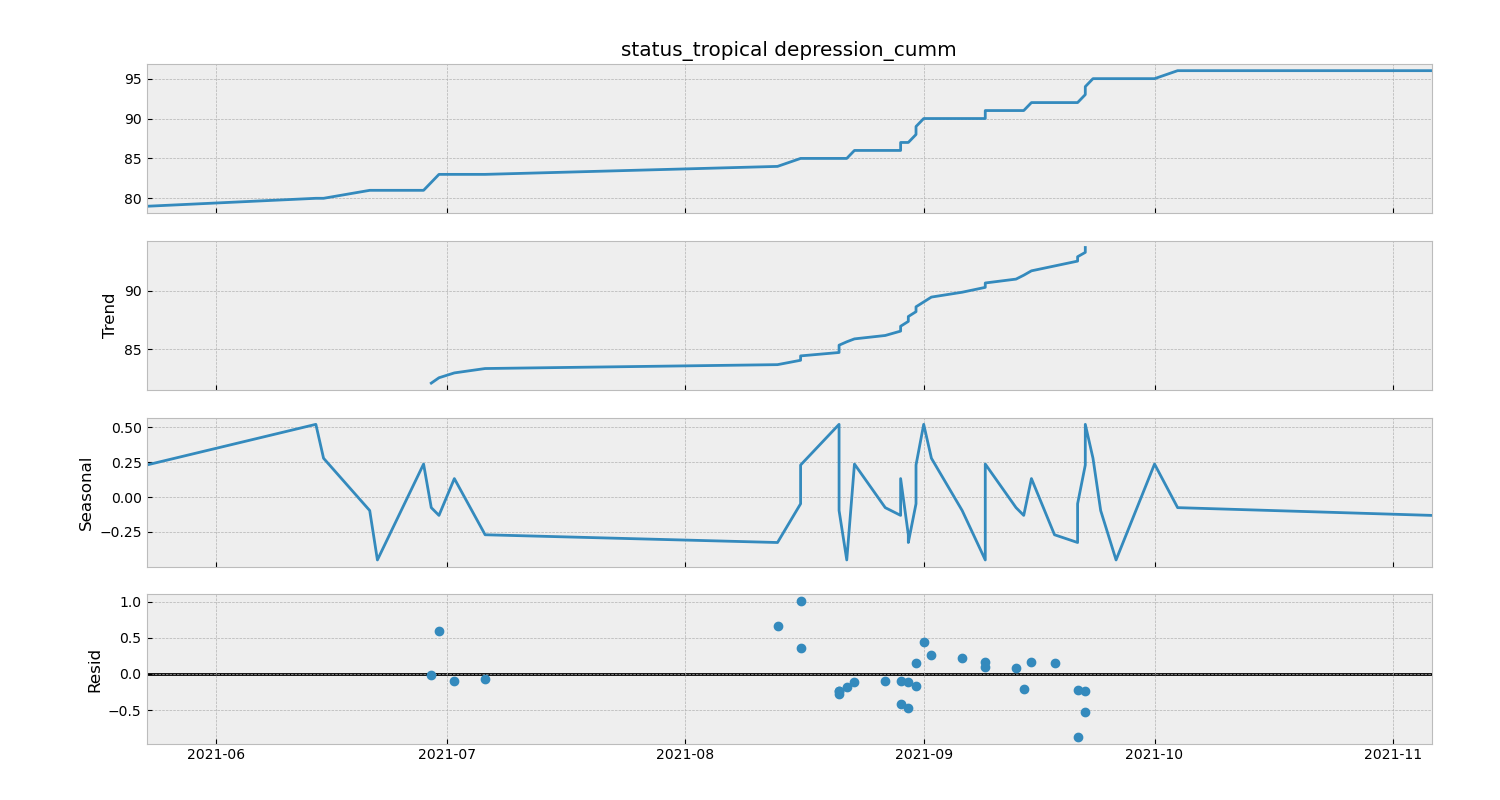

In [168]:
decomposition = seasonal_decompose(storms_ts['status_tropical depression_cumm'], period=12)    
fig = decomposition.plot()  
fig.set_size_inches(15, 8)